In [1]:
import pandas as pd
import seaborn as sns 
import functools
import operator 
import matplotlib.pyplot as plt

def read_wandb_csv(loc):
    df = pd.read_csv(loc)
    df.param_config_id = df.param_config_id.astype('str')
    return df

In [2]:
df = read_wandb_csv("F_intermediate.csv")
df["mode"] = df["catch_dropout"].fillna(1).map({0: 'FUMBRELLA', 1: 'VANILLA'})
df.columns

Index(['Name', 'State', 'Notes', 'User', 'Tags', 'Created', 'Runtime', 'Sweep',
       'ID', 'Group',
       ...
       'test_f1_best_f1', 'train_loss', 'train_p_max', 'train_p_var',
       'train_st1_loss', 'train_st1_p_max', 'train_st2_loss',
       'train_st2_p_max', 'vector_norms', 'mode'],
      dtype='object', length=112)

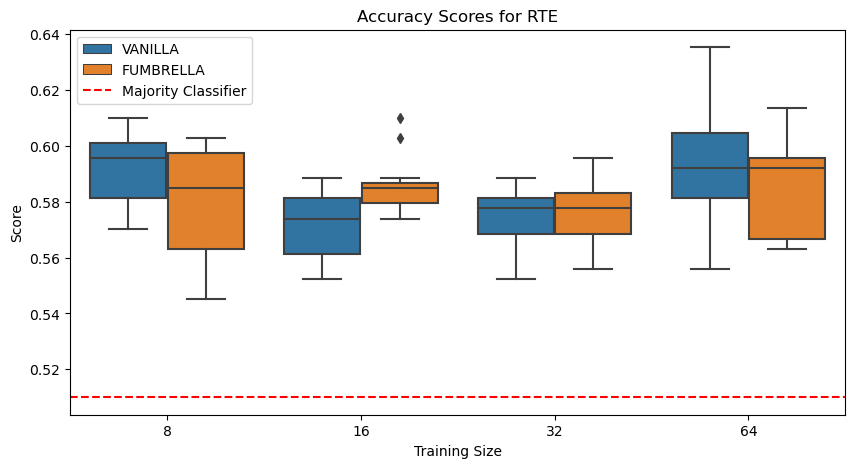

In [4]:

task_names = ['rte']
majority_classifiers = {
    'qnli' : 0.5,
    'qqp' : 0.56, # 0.63 for acc    
    'sst2' : 0.55,
    'rte': 0.51,
}
metrics = {
    'qnli' : 'accuracy',
    'qqp' : 'f1',
    'sst2' : 'accuracy',
    'rte' : 'accuracy'
}
fig, axs = plt.subplots(
    len(task_names),
    1,
    figsize = (10,5),
    )

for index, task_name in enumerate(task_names):
    metric = metrics[task_name]
    metric_key = f'test_{metric}_best_accuracy'
    selected_rows = functools.reduce(
        operator.and_,
        [
            df["task_name"] == task_name,
            # df["Tags"].str.contains('modded')
        ]  
    )
    filtered_df = df.loc[selected_rows]
    grouped_df = filtered_df.groupby(['mode','training_size', 'insert_dropout', 'learning_rate'])
    medians = grouped_df[metric_key].median()
    idx = medians.groupby(['mode','training_size']).idxmax()
    best_combinations = filtered_df.loc[filtered_df.set_index(['mode','training_size', 'insert_dropout', 'learning_rate',]).index.isin(idx)]

    ax = axs
    sns.boxplot(
        x='training_size',
        y=metric_key,
        hue='mode',
        data=best_combinations,
        ax = ax
        )
    ax.set_xlabel('Training Size')
    ax.set_ylabel('Score')
    ax.set_title(f'{metric.capitalize()} Scores for {task_name.upper()}')
    ax.axhline(
        y=majority_classifiers[task_name],
        color='r',
        linestyle='--',
        label='Majority Classifier'
        )
    ax.legend()
plt.savefig('F_intermediate_boxplot.pdf', format='pdf')